# Dataset

In [2]:
import pandas as pd
import numpy as np
from sklearn import set_config
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns

In [3]:
df = pd.read_csv("../Dataset/marketing_campaign.csv", sep='\t')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

Attributes

People

ID: Customer's unique identifier
Year_Birth: Customer's birth year
Education: Customer's education level
Marital_Status: Customer's marital status
Income: Customer's yearly household income
Kidhome: Number of children in customer's household 
Teenhome: Number of teenagers in customer's household
Dt_Customer: Date of customer's enrollment with the company
Recency: Number of days since customer's last purchase
Complain: 1 if the customer complained in the last 2 years, 0 otherwise (boolean)

Products

MntWines: Amount spent on wine in last 2 years
MntFruits: Amount spent on fruits in last 2 years
MntMeatProducts: Amount spent on meat in last 2 years
MntFishProducts: Amount spent on fish in last 2 years
MntSweetProducts: Amount spent on sweets in last 2 years
MntGoldProds: Amount spent on gold in last 2 years
Promotion

NumDealsPurchases: Number of purchases made with a discount
AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise (boolean)
AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise (boolean)
AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise (boolean)
AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise (boolean)
AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise (boolean)
Response: 1 if customer accepted the offer in the last campaign, 0 otherwise (boolean)
Place

NumWebPurchases: Number of purchases made through the company’s website
NumCatalogPurchases: Number of purchases made using a catalogue
NumStorePurchases: Number of purchases made directly in stores
NumWebVisitsMonth: Number of visits to company’s website in the last month

In [5]:
df

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,13-06-2013,46,709,...,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,10-06-2014,56,406,...,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,25-01-2014,91,908,...,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,24-01-2014,8,428,...,3,0,0,0,0,0,0,3,11,0


In [5]:
# make copy of df for transforms - DONE
# for campaigns, merge columns into column stating which campaign was accepted, if any - DONE
# combine Kidhome and Teenhome into Children column - DONE
# needed transformations: split Dt_Customer into year, month, and day columns
# one hot encode the categorical variables (education, marital status)
# clean income data (remove outliers?, fill NaN values?, impute? scale?)


#we should exclude the ID column before clustering:
# X = df.drop(columns=['ID']) 
# *perform clustering
# df[['ID', 'Cluster']].head() #map ID and clusters 


In [6]:
campaigns_dict = dict({"000000":0,"100000":1,"010000":2,"001000":3,"000100":4, "000010": 5, "000001":6})

campains_columns = ["AcceptedCmp1", "AcceptedCmp2","AcceptedCmp3","AcceptedCmp4","AcceptedCmp5", "Response"]

drops = ["AcceptedCmp1", "AcceptedCmp2","AcceptedCmp3","AcceptedCmp4","AcceptedCmp5", "Response",'campaign_success']


df_transform = df.copy()

df_transform['campaign_success'] = df_transform[campains_columns].astype(str).agg("".join, axis=1)

df_transform['campaigns']= df_transform['campaign_success'].replace(campaigns_dict)

df_transform=df_transform.drop(drops, axis=1)

df_transform



,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Z_CostContact,Z_Revenue,campaigns
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,88,3,8,10,4,7,0,3,11,6
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,6,2,1,1,2,5,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,42,1,8,2,10,4,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,5,2,2,0,4,6,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,15,5,5,3,6,5,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,13-06-2013,46,709,...,247,2,9,3,4,5,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,10-06-2014,56,406,...,8,7,8,2,5,7,0,3,11,1
2237,7270,1981,Graduation,Divorced,56981.0,0,0,25-01-2014,91,908,...,24,1,2,3,13,6,0,3,11,4
2238,8235,1956,Master,Together,69245.0,0,1,24-01-2014,8,428,...,61,2,6,5,10,3,0,3,11,0


In [7]:
# combine Kidhome and Teenhome into Children column 
df_transform['Children'] = df_transform['Kidhome'] + df_transform['Teenhome']
drops = ['Kidhome', 'Teenhome']
df_transform=df_transform.drop(drops, axis=1) 

df_transform 

,ID,Year_Birth,Education,Marital_Status,Income,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,...,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Z_CostContact,Z_Revenue,campaigns,Children
0,5524,1957,Graduation,Single,58138.0,04-09-2012,58,635,88,546,...,3,8,10,4,7,0,3,11,6,0
1,2174,1954,Graduation,Single,46344.0,08-03-2014,38,11,1,6,...,2,1,1,2,5,0,3,11,0,2
2,4141,1965,Graduation,Together,71613.0,21-08-2013,26,426,49,127,...,1,8,2,10,4,0,3,11,0,0
3,6182,1984,Graduation,Together,26646.0,10-02-2014,26,11,4,20,...,2,2,0,4,6,0,3,11,0,1
4,5324,1981,PhD,Married,58293.0,19-01-2014,94,173,43,118,...,5,5,3,6,5,0,3,11,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,13-06-2013,46,709,43,182,...,2,9,3,4,5,0,3,11,0,1
2236,4001,1946,PhD,Together,64014.0,10-06-2014,56,406,0,30,...,7,8,2,5,7,0,3,11,1,3
2237,7270,1981,Graduation,Divorced,56981.0,25-01-2014,91,908,48,217,...,1,2,3,13,6,0,3,11,4,0
2238,8235,1956,Master,Together,69245.0,24-01-2014,8,428,30,214,...,2,6,5,10,3,0,3,11,0,1


In [8]:
# convert Year_Birth to age, considering the data became available July 2024

df_transform['Age'] = 2024 - df_transform['Year_Birth']
drops = ['Year_Birth']
df_transform=df_transform.drop(drops, axis=1)

df_transform

,ID,Education,Marital_Status,Income,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Z_CostContact,Z_Revenue,campaigns,Children,Age
0,5524,Graduation,Single,58138.0,04-09-2012,58,635,88,546,172,...,8,10,4,7,0,3,11,6,0,67
1,2174,Graduation,Single,46344.0,08-03-2014,38,11,1,6,2,...,1,1,2,5,0,3,11,0,2,70
2,4141,Graduation,Together,71613.0,21-08-2013,26,426,49,127,111,...,8,2,10,4,0,3,11,0,0,59
3,6182,Graduation,Together,26646.0,10-02-2014,26,11,4,20,10,...,2,0,4,6,0,3,11,0,1,40
4,5324,PhD,Married,58293.0,19-01-2014,94,173,43,118,46,...,5,3,6,5,0,3,11,0,1,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,Graduation,Married,61223.0,13-06-2013,46,709,43,182,42,...,9,3,4,5,0,3,11,0,1,57
2236,4001,PhD,Together,64014.0,10-06-2014,56,406,0,30,0,...,8,2,5,7,0,3,11,1,3,78
2237,7270,Graduation,Divorced,56981.0,25-01-2014,91,908,48,217,32,...,2,3,13,6,0,3,11,4,0,43
2238,8235,Master,Together,69245.0,24-01-2014,8,428,30,214,80,...,6,5,10,3,0,3,11,0,1,68


In [9]:
# convert dt_customer to tenure, considering the data became available July 2024

# format date as a string
df_transform['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')

# Set the reference date — for April 2024, choose any day (e.g., April 1)
reference_date = pd.to_datetime('2024-04-01')

# Calculate the number of days they've been a customer
df_transform['days_as_customer'] = (reference_date - df_transform['Dt_Customer']).dt.days

# drop the original date column
drops = ['Dt_Customer']
df_transform=df_transform.drop(drops, axis=1)

#scaling the days_as_customer column
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_transform['days_as_customer_scaled'] = scaler.fit_transform(df_transform[['days_as_customer']])

# drop the unscaled days_as_customer column
drops = ['days_as_customer']
df_transform=df_transform.drop(drops, axis=1)

df_transform

,ID,Education,Marital_Status,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Z_CostContact,Z_Revenue,campaigns,Children,Age,days_as_customer_scaled
0,5524,Graduation,Single,58138.0,58,635,88,546,172,88,...,10,4,7,0,3,11,6,0,67,1.531185
1,2174,Graduation,Single,46344.0,38,11,1,6,2,1,...,1,2,5,0,3,11,0,2,70,-1.190545
2,4141,Graduation,Together,71613.0,26,426,49,127,111,21,...,2,10,4,0,3,11,0,0,59,-0.205773
3,6182,Graduation,Together,26646.0,26,11,4,20,10,3,...,0,4,6,0,3,11,0,1,40,-1.061881
4,5324,PhD,Married,58293.0,94,173,43,118,46,27,...,3,6,5,0,3,11,0,1,43,-0.953012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,Graduation,Married,61223.0,46,709,43,182,42,118,...,3,4,5,0,3,11,0,1,57,0.135680
2236,4001,PhD,Together,64014.0,56,406,0,30,0,0,...,2,5,7,0,3,11,1,3,78,-1.655713
2237,7270,Graduation,Divorced,56981.0,91,908,48,217,32,12,...,3,13,6,0,3,11,4,0,43,-0.982703
2238,8235,Master,Together,69245.0,8,428,30,214,80,30,...,5,10,3,0,3,11,0,1,68,-0.977755


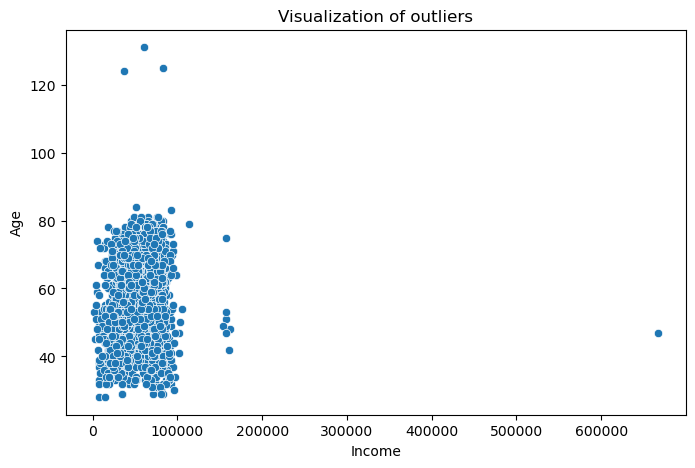

In [11]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(data=df_transform, y='Age', x='Income', ax=ax)
ax.set_title("Visualization of outliers")
plt.show()

In [12]:
df_transform_outliers = df_transform.copy()
#keep only rows where Year_Birth is after 1930 and Income is less than 200,000 to exclude extreme values
df_transform_outliers = df_transform_outliers[
    (df_transform_outliers["Age"] < 120) & 
    (df_transform_outliers["Income"] < 200000)
]

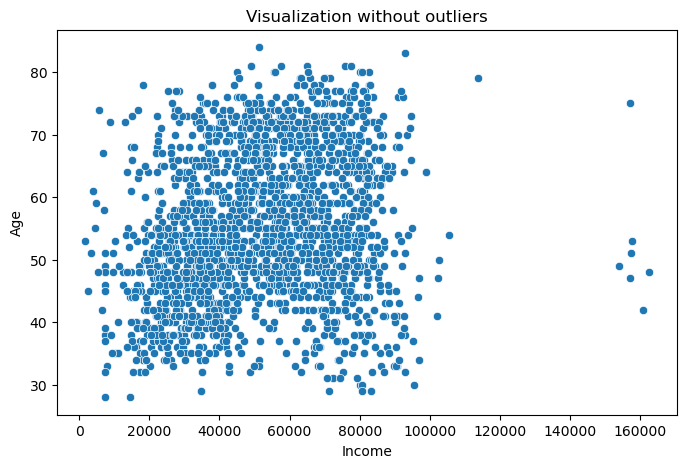

In [14]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(data=df_transform_outliers, y='Age', x='Income', ax=ax)
ax.set_title("Visualization without outliers")
plt.show()